# Using Wavelet Scattering Transform to analyse 1D signals (electroencephalograms)

## Introduction

In previous notebooks we used the 2D implementation of the WST to analyse images. Here we look at 1D examples by extracting information from EEG signals and trying to generate new data.

We need to have the `kymatio` package installed (https://www.kymat.io/). See https://www.kymat.io/gallery_1d/index.html for more 1D examples, including classification tasks.

In [1]:
import datetime

import numpy as np

import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering1D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Selecting {device} as computing device.')

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

Selecting cuda as computing device.


## Load examples

EEGs are from https://zenodo.org/record/3684992 (CC-BY S. Panwar)

In [38]:
files = [
    'inputs/EEG/E10_1.txt',
    'inputs/EEG/H10_1.txt',
]

In [39]:
EEGs = []
for name in files:
    EEGs.append(np.loadtxt(name, dtype=np.single)[:2**12])

4096
4096


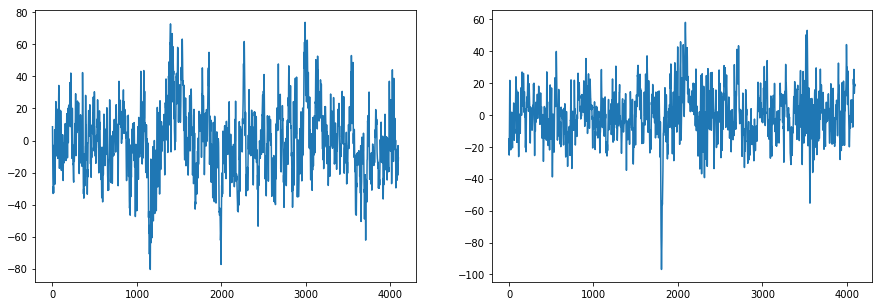

In [40]:
plt.rcParams["figure.figsize"] = (15,5)
figure, ax = plt.subplots(ncols=len(EEGs))
for i, EEG in enumerate(EEGs):
    ax[i].plot(EEG)
    print(len(EEG))

## Define scattering moments

Because we want a translation-invariant model, the wavelet decomposition is performed for all scales `J` in order to get the average value as the output of the scattering transform. See https://www.kymat.io/userguide.html. `Q` is the number of scales per octave. 

In [47]:
# Define Wavelet Scattering Transform
print("Defining WST (this step can be slow)...")
Q = 1
J = int(np.log2(len(EEGs[0]))) # Full scale for stationary processes
print(J)
wst = Scattering1D(J, len(EEGs[0]), Q)
wst = wst.cuda()

def S(x):
    """Define scattering transform"""
    return wst(x).flatten()

Defining WST (this step can be slow)...
12


## Micro-canonical method

In this method, we generate a new signal, $x_1$, such that:
$$
|S(x)-S(x_0)| < \varepsilon
$$
where $S(x)$ is the scattering transform and $x_0$ is the example EEG. In other words, we use an optimization process so that $x_1$ has the same scattering moments as the example. 

This is a non-convex problem and therefore turns out to be very difficult in practice. Optimizer type, meta-parameters, initialization, etc. play a crucial role.

In [49]:
# Select image number
i = 1

# Compute scattering transform of the example
EEG = EEGs[i]
S0 = S(torch.from_numpy(EEG).to(device).contiguous())

S0_plot = S0.detach().cpu()

# Create trainable image
# ----------------------

# From random values
x = torch.randn(EEG.shape, requires_grad=True, device=device)


# Optimizer
# ---------
optimizer = optim.Adam([x], lr=1.)
#optimizer = optim.SGD([x], lr=1e4, momentum=0.9, dampening=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100)


# Optimization loop
# -----------------
max_iter = 10_000
losses = []

for epoch in range(max_iter):
    S1 = S(x)
    #loss = F.mse_loss(input=S1, target=S0)
    loss = F.l1_loss(input=S(x), target=S0)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())
    losses.append(loss.item())
    
    if epoch%10==0:
        # Plotting
        current_EEG = x.detach().cpu().numpy()
        clear_output(wait=True)
        
        
        plt.rcParams["figure.figsize"] = (18,4)
        figure, ax = plt.subplots(ncols=4)
        ax[0].plot(EEG)
        ax[0].set_title("Example")

        ax[1].plot(current_EEG)
        #ax[1].set_title(f"Epoch {epoch}, lr: {scheduler.get_last_lr()[0]:1.6f}, loss: {loss.item():1.3e}")
        ax[1].set_title(f"Epoch {epoch}, lr: {scheduler._last_lr[0]:1.3e}, loss: {loss.item():1.4e}")

        if len(losses) < 50:
            ls = 'o-'
        else:
            ls = '-'
        ax[2].semilogy(losses, ls)
        ax[2].set_xlabel('Epoch')
        ax[2].set_title('Loss')
        
        ax[3].loglog(S0_plot, S0_plot, 'k-', alpha=0.1)
        ax[3].loglog(S0_plot, S1.detach().cpu(), '.', alpha=0.2)
        ax[3].set_title('Scattering coefficients')
        ax[3].set_xlabel('Target')
        ax[3].set_ylabel('Current sample')
        plt.show()

KeyboardInterrupt: 

## Macro-canonical method (work in progress)

Now the scattering moments are used as variables of a maximum-entropy model. The probability of sampling a given image $x$ is assumed to be:
$$
P(x) \propto e^{-\beta \cdot S(x)}
$$
where $\beta$ is the vector of Lagrange multiplyers. We don't know $\beta$ and we don't know the normalization factor of the distribution, so we are going to apply a Markov Chain Monte Carlo (MCMC) method to jointly solve this problem. As described by De Bortoli *et al.*, this is an iterative process with two inner steps:

1. Sample images using an overdamped Langevin algorithm (https://en.wikipedia.org/wiki/Brownian_dynamics): 
$$
x_{n+1} = x_n -\gamma \beta \cdot \nabla_x S(x_n) + \sqrt{2\gamma}W_{n+1}
$$
with $\gamma$ a step (in units of m² in Brownian dynamics), $W$ a white noise. From the mechanical analogy, the gradient term will force the scattering coefficients towards lower values, while the noise will keep them at a certain level.

2. When step one has converged towards a stationary process, use the samples to calculate the empirical average $\langle S(x) \rangle$ and update the Lagrange multiplyers so that $\langle S(x) \rangle$ tends towards $S(x_0)$:
$$
\beta_{n+1} = \beta_n + \delta \left( \langle S(x) \rangle - S(x_0)  \right)
$$
where $\delta$ is the step.

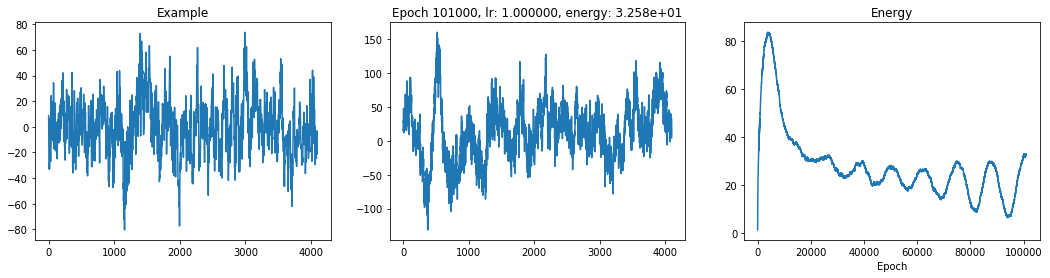

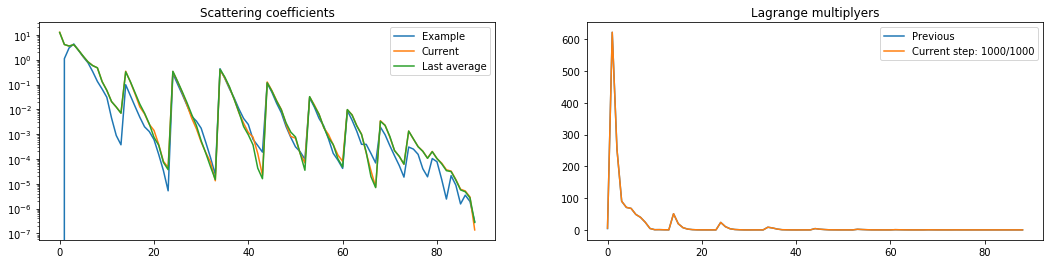

Maximum beta increment: 1.3264975547790527


In [68]:
# Select image number
i = 0

EEG = EEGs[i]


S0 = S(torch.from_numpy(EEG).to(device).contiguous())
S0_plot = S0.detach().cpu().numpy()

# Start with uniform beta
beta = torch.full((len(S0),), 1.0, device=device)
beta_old = beta.cpu()

# Noise tensor
W = torch.randn(EEG.shape, device=device)

# Start with random image
x = torch.randn(EEG.shape, requires_grad=True, device=device)


optimizer = optim.SGD([x], lr=1.)  # Note that the learning rate (lr) also governs the level of noise.
equilibrium_iter = 10 # Number of steps before stationarity is assumed
take_every = 10 # Take every other sample to calculate average, rest is discarded
num_sample = 10 # Number of samples to collect before updating Lagrange multiplyers
sample_avg = None  #Will be populated with scattering average

# Record energy
energies = []
epoch = 0


# Step for Lagrange multiplyers update
delta = .1

# Number of updates
num_outer = 1000


# Start outer loop
for outer in range(num_outer):

    samples = []
    
    # Inner loop
    for inner in range(equilibrium_iter + take_every*(num_sample-1) + 1):

        epoch += 1
        # Compute current energy
        S1 = S(x)
        loss = torch.sum(beta*S1)

        # Compute and apply deterministric force
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            # Add updated random noise
            x += np.sqrt(2*optimizer.param_groups[0]['lr'])*W.normal_()

            # Crop at both ends
            #x[x>1] = 1
            #x[x<0] = 0

            # Bounce at both ends
            #x[x>1] = 2 - x[x>1]
            #x[x<0] = - x[x<0]


        energies.append(np.sum(S1.detach().cpu().numpy()))

        # Collecting samples
        collecting_i = inner - equilibrium_iter
        collecting = collecting_i >-1 and collecting_i%take_every==0
        if collecting:
            samples.append(S1.detach().cpu().numpy())

        # Plotting
        if inner%10 == 0 or collecting:
            current_EEG = x.detach().cpu().numpy()
            S1_plot = S1.detach().cpu().numpy()

            clear_output(wait=True)
            figure, ax = plt.subplots(ncols=3)
            ax[0].plot(EEG)
            ax[0].set_title("Example")

            ax[1].plot(current_EEG)
            ax[1].set_title(f"Epoch {epoch}, lr: {optimizer.param_groups[0]['lr']:1.6f}, energy: {energies[-1]:1.3e}")

            if len(energies) < 50:
                ls = 'o-'
            else:
                ls = '-'
            ax[2].plot(energies, ls)
            ax[2].set_xlabel('Epoch')
            ax[2].set_title('Energy')
            plt.show()

            figure, ax = plt.subplots(ncols=2)
            ax[0].semilogy(S0_plot, label='Example')
            ax[0].semilogy(S1_plot, label='Current')
            if sample_avg is not None:
                ax[0].semilogy(sample_avg, label='Last average')
            ax[0].legend()
            ax[0].set_title('Scattering coefficients')

            ax[1].set_title('Lagrange multiplyers')
            ax[1].plot(beta_old, label='Previous')
            ax[1].plot(beta.cpu(), label=f'Current step: {outer+1}/{num_outer}')
            ax[1].legend()

        #    ax[3].hist(best_img.flatten(), np.linspace(0,1,100), density=True)
        #    ax[3].set_title('Histogram')

        #    ax[3].semilogy(S1_plot, label='Current sample')
        #    ax[3].semilogy(S0_plot, label='Example')
        #    ax[3].set_xlabel('Coefficients')
        #    ax[3].set_ylabel('Value')
        #    ax[3].legend()
            plt.show()
            
    # Now that we have collected samples, perform the average
    sample_avg = np.average(np.array(samples), axis=0)
    
    print(f'Maximum beta increment: {delta*np.amax(np.abs(sample_avg- S0_plot))}')
    
    # And update Lagrange multiplyers:
    beta_old = beta.cpu()
    beta += delta*(torch.tensor(sample_avg, device=device) - S0) 